In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from splitkci import dependence_measures
from splitkci import pval_computations
from splitkci import cond_mean_estimation as cme
import scipy
import seaborn as sns

def get_error_mean_std(data, ground_truth, pval):
    if ground_truth == 'H0':
        data = 1 - (data >= pval).float()
    else:
        data = (data >= pval).float()

    mean = data.mean(dim=(-2, -1))
    std = data.std(dim=(-2, -1))
    return mean, std

In [2]:
import warnings
warnings.filterwarnings('ignore')#action='once')#'ignore')

In [3]:
results_location = os.path.join(os.environ['SCRATCH'], 'splitkci_testing_results/ratinabox')
names = {'kci': 'KCI', 'kci_asplit': 'SplitKCI (A only)', 'circe': 'CIRCE', 'gcm': 'GCM', 'rbpt2_ub': 'RBPT2\'',
            'rbpt2': 'RBPT2', 'kci_absplit': 'SplitKCI', 'circe_bsplit': 'SplitCIRCE'}
colors = {'kci': '#0072B2', 'kci_asplit': '#009E73',
          'circe': '#821651', 'gcm': '#E69F00', 
          'rbpt2_ub': '#D55E00', 'rbpt2': '#000000', 'kci_absplit': '#000000',
          'circe_bsplit': '#808080'}
plt.rcParams["svg.fonttype"] = 'none'

In [4]:
# your folder with results. Everything will be saved in './figs'
folder = '/network/scratch/r/roman.pogodin/splitkci_testing_results/'
task = 'ratinabox'

In [5]:
def plot_pvals(measures_list, figure_path, 
               task='ratinabox', dim=100, kernels='all',
               h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
               log_scale=False, budget=0, min_n=200,
               abc='joint'):

    points_list = torch.linspace(min_n, 1000, (1000 - min_n) // 100 + 1).int()
    ticks = [str(i.item()) for i in points_list]

    fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=True)

    pval = 0.05
    
    for gt_idx, ground_truth in enumerate(['H0', 'H1']):
        axes[gt_idx].set_xlabel(r'$N$')
        axes[gt_idx].set_xticks(points_list, ticks)
        
        for measure in measures_list:
            ##################
            # loading data
            data = torch.zeros(len(points_list), 100, 1)
            if '_gamma' == measure[-6:]:
                gamma_idx = '_gamma'
                measure = measure[:-6]
                measure_ls = ':'
            else:
                gamma_idx = ''
                measure_ls = '-'
            suff = measure.split('__')[1]
            base_measure = measure.split('__')[0]
                
            for idx, n_points in enumerate(points_list):
                kernels_actual = kernels
                
                if abc == 'joint':
                    file = f'{task}_0.05_both_0.05_{base_measure}_{kernels_actual}_{abc}' + \
                        f'_{budget}_{min_n}_{ground_truth}{gamma_idx}seeds0_100_d{dim}_abc{n_points}_aux0_{suff}.pt'
                elif abc == 'separate':
                    file = f'{task}_0.05_both_0.05_{base_measure}_{kernels_actual}_{abc}' + \
                        f'_{budget}_{min_n}_{ground_truth}{gamma_idx}seeds0_100_d{dim}_abc{budget}_aux{n_points}_{suff}.pt'
                data[idx] = torch.load(os.path.join(folder, task, file))

            mean, std = get_error_mean_std(data, ground_truth, pval)
            ##################

            sqn_x = np.sqrt(data.shape[1])
            label = names[base_measure]
            color = colors[base_measure]

            axes[gt_idx].plot(points_list, mean, label=label, color=color, linestyle=measure_ls)
            axes[gt_idx].fill_between(points_list, 
                                      mean - std / sqn_x, 
                                      mean + std / sqn_x, alpha=0.05, color=color)

    

    axes[0].axhline(pval, color='r', linestyle='--', label=fr'$\alpha$={pval}')
    axes[0].set_ylabel(fr'Type I error')
    axes[1].set_ylabel(fr'Type II error')
    
    axes[0].set_ylim(h0_min, h0_max)
    axes[1].set_ylim(h1_min, h1_max)
    
    if log_scale:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
        

    axes[0].legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.savefig(figure_path, transparent=True)
    plt.show()

# checks

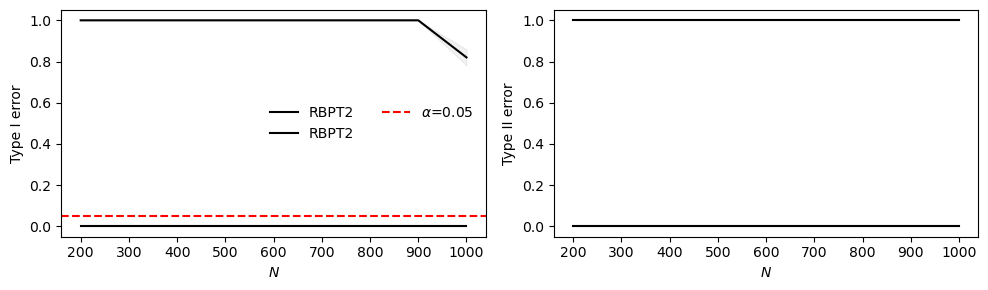

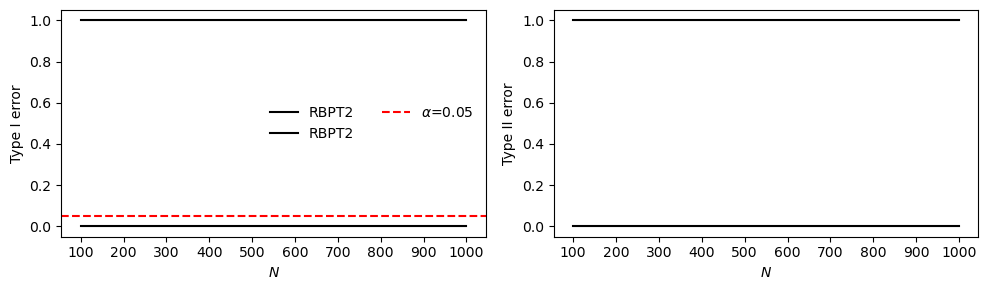

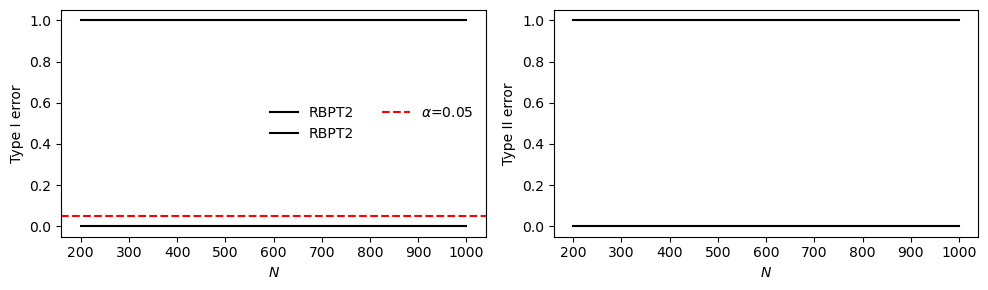

In [23]:
measures_list = [
# #                 'circe__control',
# #                 'circe__ttsplit_0.5', 
# #                 'circe__ttsplit_100',
# #                 'circe__ttsplit_False',
# #                 'kci__control',
# #                 'kci__ttsplit_0.5', 
#                 'kci__ttsplit_100',
#                 'kci__ttsplit_200',
#                 'kci__ttsplit_False',
# #                 'kci_asplit__control',
# #                 'kci_asplit__ttsplit_0.5', 
#                 'kci_asplit__ttsplit_100',
#                 'kci_asplit__ttsplit_200',
#                 'kci_asplit__ttsplit_False',
# #                 'kci_absplit__control',
# #                 'kci_absplit__ttsplit_0.5', 
#                 'kci_absplit__ttsplit_100',
#                 'kci_asplit__ttsplit_200',
#                 'kci_absplit__ttsplit_False',
#                 'kci_absplit__ttsplit_auto',
# #                 'gcm__control',
# #                 'gcm__ttsplit_0.5', 
#                 'gcm__ttsplit_100',
#                 'gcm__ttsplit_200',
#                 'gcm__ttsplit_False', 
# #                 'rbpt2_ub__control',
# #                 'rbpt2_ub__ttsplit_0.5', 
#                 'rbpt2_ub__ttsplit_100',
#                 'rbpt2_ub__ttsplit_200',
#                 'rbpt2_ub__ttsplit_False',
#                 'rbpt2__control',
#                 'rbpt2__ttsplit_0.5', 
                'rbpt2__ttsplit_100',
#                 'rbpt2__ttsplit_200',
                'rbpt2__ttsplit_False',
                ]


plot_pvals(measures_list, 'figs/test.svg', 
                    task='ratinabox', dim=100, kernels='all',
                    h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
                    log_scale=False, budget=0, min_n=200, abc='joint')


plot_pvals(measures_list, 'figs/test.svg', 
                    task='ratinabox', dim=100, kernels='all',
                    h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
                    log_scale=False, budget=200, min_n=100, abc='separate')

plot_pvals(measures_list, 'figs/test.svg', 
                    task='ratinabox', dim=100, kernels='all',
                    h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
                    log_scale=False, budget=400, min_n=200, abc='separate')

# Main text

## best standard

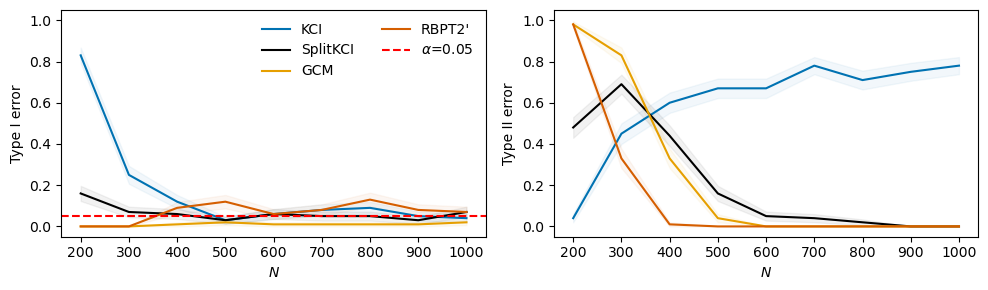

In [28]:
measures_list = [
                'kci__ttsplit_100',
                'kci_absplit__ttsplit_auto',
                'gcm__ttsplit_False', 
                'rbpt2_ub__ttsplit_100',
                ]

plot_pvals(measures_list, 'figs/fig_standard_data.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=0, min_n=200, abc='joint')

# best ax

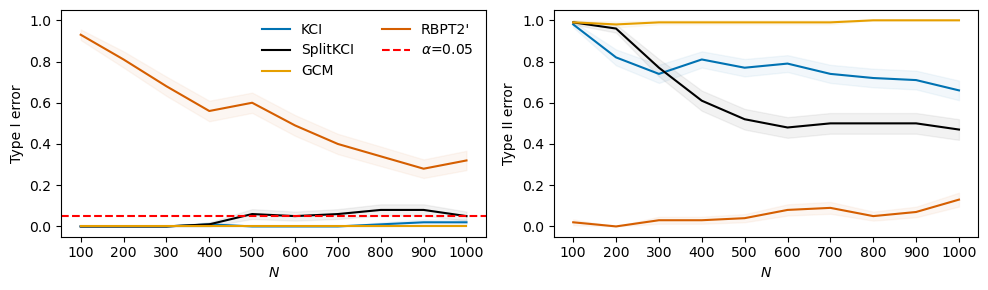

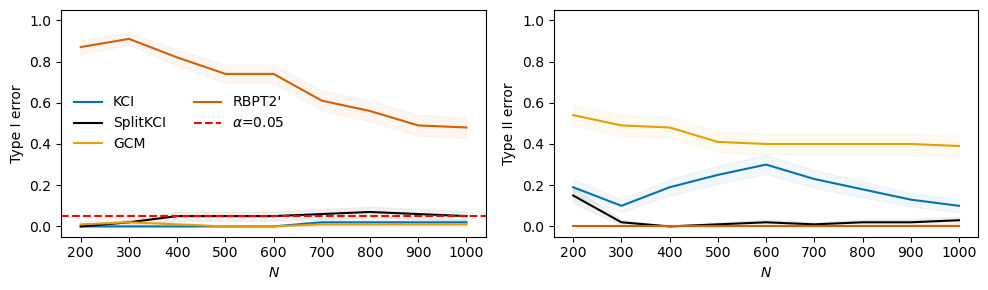

In [29]:
measures_list = [
                'kci__ttsplit_False',
                'kci_absplit__ttsplit_False',
                'gcm__ttsplit_False',
                'rbpt2_ub__ttsplit_100',
                ]

plot_pvals(measures_list, 'figs/fig_aux_data_200.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=200, min_n=100, abc='separate')

plot_pvals(measures_list, 'figs/fig_aux_data_400.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=400, min_n=200, abc='separate')

# Appendix

## Standard

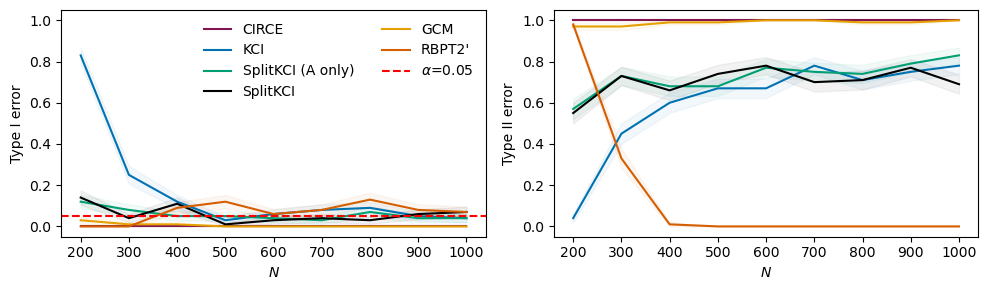

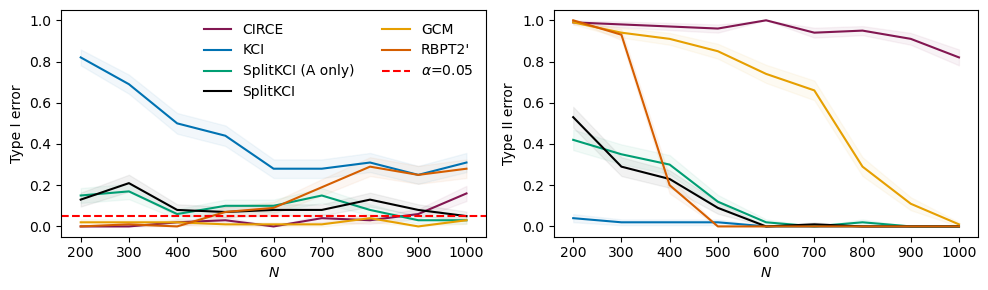

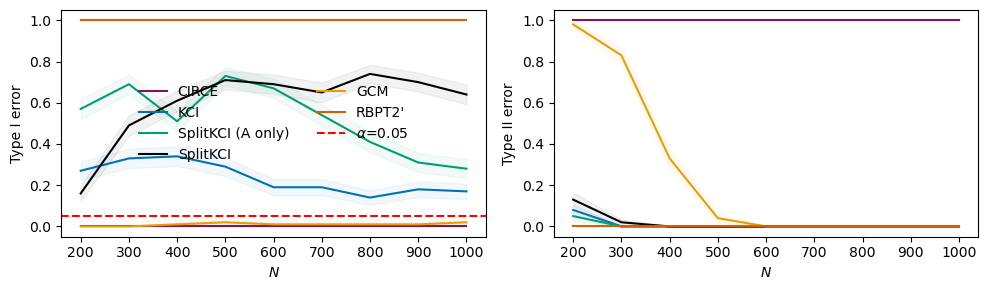

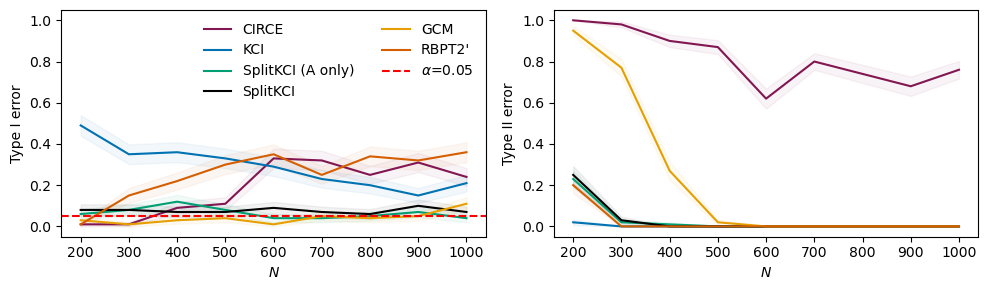

In [30]:
measures_list = [
                'circe__ttsplit_100',
                'kci__ttsplit_100',
                'kci_asplit__ttsplit_100',
                'kci_absplit__ttsplit_100',
                'gcm__ttsplit_100', 
                'rbpt2_ub__ttsplit_100',
                ]

plot_pvals(measures_list, 'figs/fig_app_standard_data_100.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=0, min_n=200, abc='joint')


measures_list = [
                'circe__ttsplit_0.5',
                'kci__ttsplit_0.5',
                'kci_asplit__ttsplit_0.5',
                'kci_absplit__ttsplit_0.5',
                'gcm__ttsplit_0.5',
                'rbpt2_ub__ttsplit_0.5',
                ]

plot_pvals(measures_list, 'figs/fig_app_standard_data_0.5.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=0, min_n=200, abc='joint')


measures_list = [
                'circe__ttsplit_False',
                'kci__ttsplit_False',
                'kci_asplit__ttsplit_False',
                'kci_absplit__ttsplit_False',
                'gcm__ttsplit_False',
                'rbpt2_ub__ttsplit_False',
                ]

plot_pvals(measures_list, 'figs/fig_app_standard_data_False.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=0, min_n=200, abc='joint')



measures_list = [
                'circe__control',
                'kci__control',
                'kci_asplit__control',
                'kci_absplit__control',
                'gcm__control',
                'rbpt2_ub__control',
                ]
    
plot_pvals(measures_list, 'figs/fig_app_standard_data_control.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=0, min_n=200, abc='joint')


## Aux

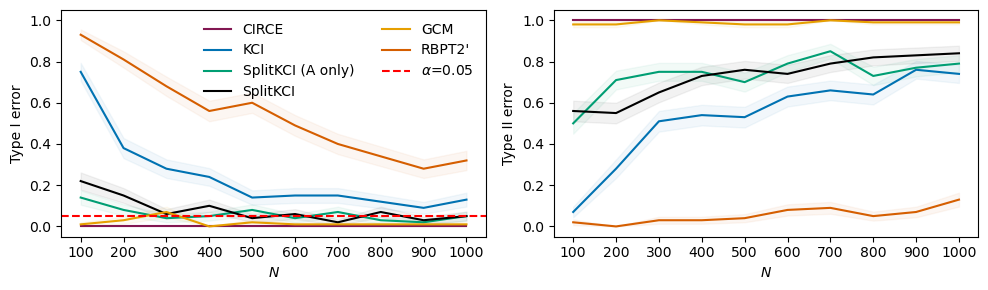

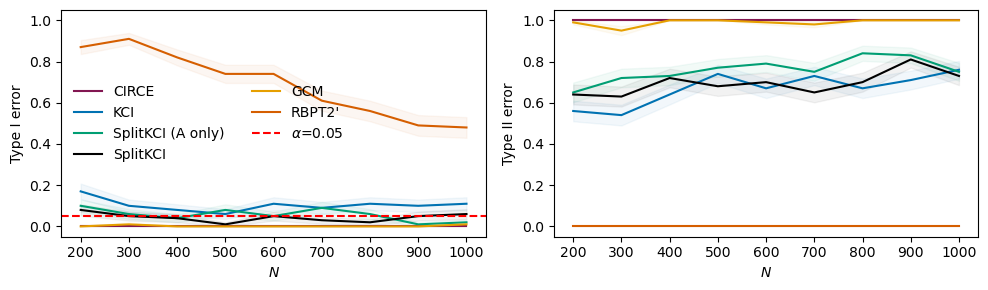

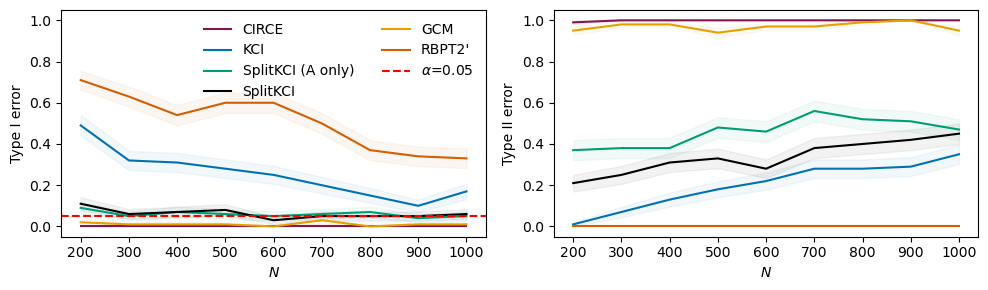

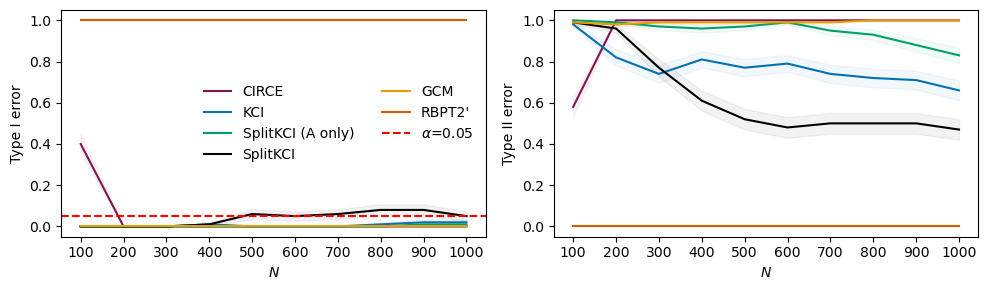

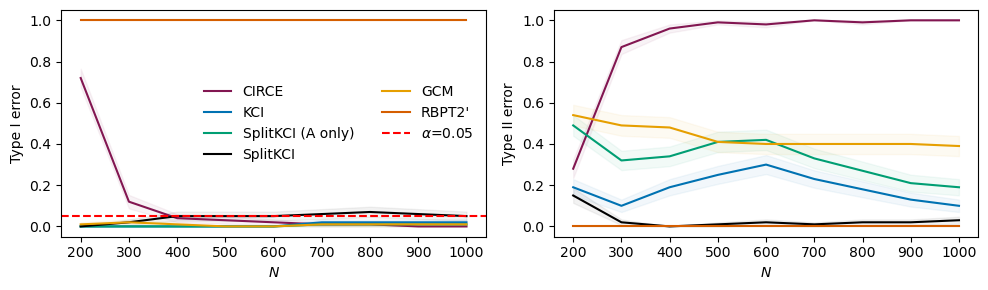

In [31]:
measures_list = [
                'circe__ttsplit_100',
                'kci__ttsplit_100',
                'kci_asplit__ttsplit_100',
                'kci_absplit__ttsplit_100',
                'gcm__ttsplit_100',
                'rbpt2_ub__ttsplit_100',
                ]
            
    
plot_pvals(measures_list, 'figs/fig_app_aux_data_200_100.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=200, min_n=100, abc='separate')

plot_pvals(measures_list, 'figs/fig_app_aux_data_400_100.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=400, min_n=200, abc='separate')


measures_list = [
                'circe__ttsplit_200',
                'kci__ttsplit_200',
                'kci_asplit__ttsplit_200',
                'kci_absplit__ttsplit_200',
                'gcm__ttsplit_200',
                'rbpt2_ub__ttsplit_200',
                ]

plot_pvals(measures_list, 'figs/fig_app_aux_data_400_200.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=400, min_n=200, abc='separate')

measures_list = [
                'circe__ttsplit_False',
                'kci__ttsplit_False',
                'kci_asplit__ttsplit_False',
                'kci_absplit__ttsplit_False',
                'gcm__ttsplit_False',
                'rbpt2_ub__ttsplit_False',
                ]
            
plot_pvals(measures_list, 'figs/fig_app_aux_data_200_False.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=200, min_n=100, abc='separate')

plot_pvals(measures_list, 'figs/fig_app_aux_data_400_False.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=400, min_n=200, abc='separate')

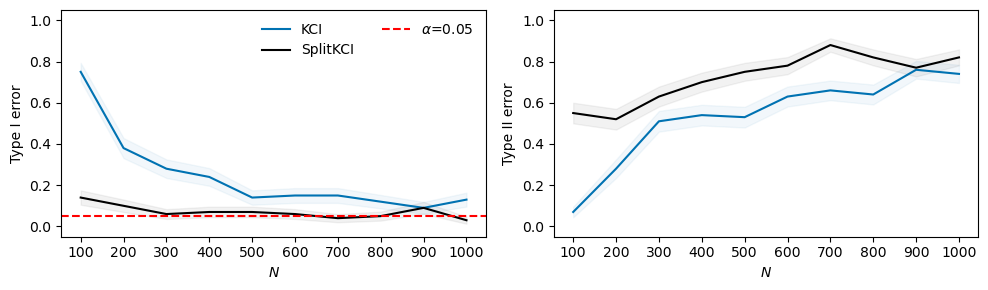

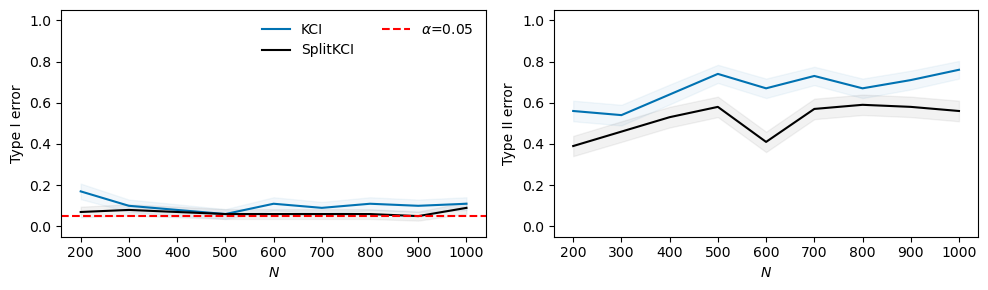

In [7]:
measures_list = [
                'kci__ttsplit_100',
                'kci_absplit__ttsplit_auto',
                ]
            
plot_pvals(measures_list, 'figs/fig_app_aux_data_200_SplitKCI_auto_vs_KCI_100.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=200, min_n=100, abc='separate')

plot_pvals(measures_list, 'figs/fig_app_aux_data_400_SplitKCI_auto_vs_KCI_100.svg', 
        task='ratinabox', dim=100, kernels='all',
        h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
        log_scale=False, budget=400, min_n=200, abc='separate')

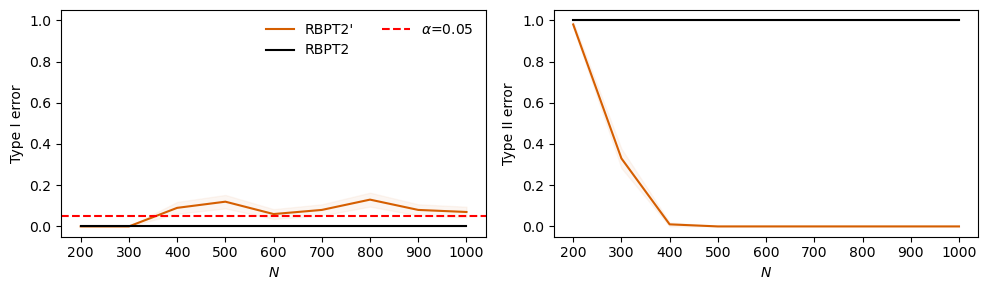

In [28]:
measures_list = [
                'rbpt2_ub__ttsplit_100',
                'rbpt2__ttsplit_100',
                ]


plot_pvals(measures_list, 'figs/test.svg', 
                    task='ratinabox', dim=100, kernels='all',
                    h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
                    log_scale=False, budget=0, min_n=200, abc='joint')

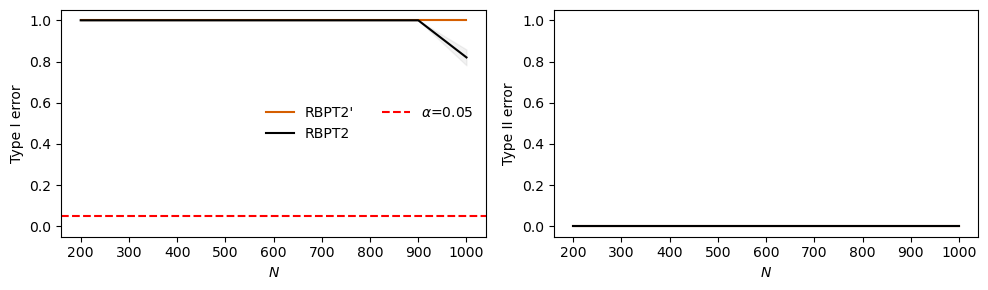

In [29]:
measures_list = [
                'rbpt2_ub__ttsplit_False',
                'rbpt2__ttsplit_False',
                ]


plot_pvals(measures_list, 'figs/test.svg', 
                    task='ratinabox', dim=100, kernels='all',
                    h0_max=1.05, h0_min=-0.05, h1_max=1.05, h1_min=-0.05,
                    log_scale=False, budget=0, min_n=200, abc='joint')

# Zip

In [32]:
!zip -r figs.zip ./figs/

updating: figs/ (stored 0%)
updating: figs/app_rbpt_comparison.svg (deflated 83%)
updating: figs/fig_app_standard_data_False.svg (deflated 88%)
updating: figs/app_gamma_comparison.svg (deflated 85%)
updating: figs/cars_sim.svg (deflated 86%)
updating: figs/budget_H1.svg (deflated 88%)
updating: figs/fig_app_standard_data_0.5.svg (deflated 87%)
updating: figs/fig_app_standard_data_100.svg (deflated 87%)
updating: figs/fig_app_aux_data_400_False.svg (deflated 87%)
updating: figs/budget_H0.svg (deflated 88%)
updating: figs/app_wild_comparison.svg (deflated 85%)
updating: figs/fig_app_aux_data_200_False.svg (deflated 88%)
updating: figs/fig_app_aux_data_200_100.svg (deflated 86%)
updating: figs/test.svg (deflated 88%)
updating: figs/fig_app_standard_data_control.svg (deflated 87%)
updating: figs/fig_app_aux_data_400_100.svg (deflated 87%)
updating: figs/cars_true.svg (deflated 88%)
updating: figs/fig_aux_data_200.svg (deflated 87%)
updating: figs/fig_aux_data_400.svg (deflated 87%)
updatin